# An Alternative method to LCA - Linear Concept Compression

This Notebook is a part of the Thesis Project: Learning Multilingual Document Representations.
(Marc Lenz, 2021)


** **

## Motivation



**Linear Concept approximation - Recap**

In linear concept approximation the initial input are is a bilingual set of low-dimensional document representations. 
Those are obtained before by applying a k-truncated Singular Value Decomposition to the (weighted) Bag-of-Words vectors. 

These low-dimensional representations should be called concept-representations. For our given bilingual set of documents, we will denote the concept-vector Matrices of two languages $L_{x}, L_{y}$ with $C_{x}, C_{y}$. The columns of those matrices are the concept-representations of a document. In Linear concept approximation the idea is now that the represented concepts are quite similar. However, we cant compare the representations directly since they were derived independently from each other and a concept which is encoded in a certain dimension of x might be encoded in another dimension of y. What we might be able to do though is to align them by a linear transformation. In order to obtain this, we want to learn a mappings $\theta_{1}, \theta_{2} \in \mathbb{R}^{d \times d}$ such that:

$c_{x}(d)\theta_{1} = c_{y}(d)$ and $c_{y}(d)\theta_{2} = c_{x}(d)$

We do this by minimizing $||C_{x}\theta-C_{y}||_{2}^{2}$ and $||C_{y}\theta-C_{x}||_{2}^{2}$ 

Then we can obtain new, bilingual representations for each document d by
extending $c_{x}(d) \rightarrow [c_{x}(d), c_{x}(d)\theta_{1}]$ and respectively $c_{y}(d) \rightarrow [c_{y}(d)\theta_{1}, c_{y}(d)]$

**Initial thought: We create Information Redundancy**

- Lets look at the mapping we obtained for a moment. $\phi (c_{x}(d)) \rightarrow [c_{x}(d), c_{x}(d)\theta_{1}]$ , $\phi : \mathbb{R}^{d} \rightarrow \mathbb{R}^{2d}$. 
- Even if $Image(\phi)\in \mathbb{R}^{2d}$, it is $Dim(Image(\phi)) \leq d$, since $Dim(Image(\phi)) = Rank(\phi) = Dim(\mathbb{R}^{d}) - Nullity(\phi) = d - Nullity(\phi)$.

- So that the **true dimensionality** of the new representation is still d. 





## Approach

**Idea:**
- Find a mappings $\theta_{1},\theta_{2}$ such that $c_{x}(d)\theta_{1} = c_{y}(d)\theta_{2}$ but preserves information of $c_{x},c_{y}$
- The intuition is to find an Encoder-Decoder approach. The purpose of the Encoder is to encode monolingual representations in a language-indepent way. The purpose of the decoder is to reconstruct the monolingual representations of multiple languages from that encoding. 

Keeping the Encoder and Decoder linear, this could be done via minimizing the following system of linear equations:

$
\|
\begin{bmatrix}
C_{x} & 0 \\
0 & C_{y} 
\end{bmatrix}
\underbrace{\begin{bmatrix}
E_{x}\\
E_{y}
\end{bmatrix} }_{\in \mathbb{R}^{2d \times d}}
\underbrace{\begin{bmatrix}
D_{x} & D_{y}
\end{bmatrix}}_{\in \mathbb{R}^{d \times 2d}}
-
\begin{bmatrix}
C_{x} & C_{x}\\
C_{y}  & C_{y} 
\end{bmatrix}
\|_{2}
$
$
=
\|
\begin{bmatrix}
C_{x}E_{x}D_{x} - C_{x} & C_{y}E_{y}D_{x} - C_{x}\\
C_{y}E_{y}D_{y} - C_{y}  & C_{x}E_{x}D_{y} - C_{y} 
\end{bmatrix}
\|_{2}
$


- Now this is equivalent to minimizing 
$min_{rg(A)=d}\|
\begin{bmatrix}
C_{x} & 0 \\
0 & C_{y} 
\end{bmatrix} A -
\begin{bmatrix}
C_{x} & C_{x}\\
C_{y}  & C_{y} 
\end{bmatrix}
\|_{2}
$
And then finding a decomposition of A such that $A = ED$


**Solving Reduced Rank Regression**

The problem we are facing here is reduced rank regression (rrr). If we take a few assumptions for our random variables such as $X \in \mathbb{R}^{d} $ and $Y \in \mathbb{R}^{d} $ satisfy $E(X) = 0, E(Y ) = 0, E(Y |X) = X\phi.$, then we can solve it. 


$ L=\|\mathbf Y-\mathbf X\mathbf B\|^2_{rg(B) = d} = \|\mathbf Y-\mathbf X\hat{\mathbf B}_\mathrm{OLS}\|^2+\|\mathbf X\hat{\mathbf B}_\mathrm{OLS}-\mathbf X\mathbf B\|^2_{rg(B) = d}.$

Now, B does not have any influence on the left term. For the right term, we can apply the Eckardt-Young Theorem
And therefore an optimal solution is given by the d-truncated singular value decomposition of $X\hat{\mathbf B}_\mathrm{OLS}$. 
Let $X\hat{\mathbf B}_\mathrm{OLS} = U \Sigma V$. Then $B_{rrr}$ is given by:
${\mathbf B}_\mathrm{OLS}U^{t}_{d}U_{d}$

Finally, we define: 
$E = {\mathbf B}_\mathrm{OLS}U^{t}_{d}$ and $D = U_{d}$


**Practical Solution**

- compute $\hat{\mathbf B}_\mathrm{OLS} = arg min_\|
\begin{bmatrix}
C_{x} & 0 \\
0 & C_{y} 
\end{bmatrix} A -
\begin{bmatrix}
C_{x} & C_{x}\\
C_{y}  & C_{y} 
\end{bmatrix}
\|_{2}$
- Compute the SVD $X\hat{\mathbf B}_\mathrm{OLS} = U \Sigma V$ 
- Define $E:= \hat{\mathbf B}_\mathrm{OLS}U^{t} $

##  1. Create the LSI Models/SVD for Preprocessed Data

The original JRC-Arquis dataset have been preprocessed before. 
The aligned documents have been saved in two seperate csv files. 
For details of the preprocessing, check: read_and_preprocess.py

In [1]:
from Utils import read_docs
from sklearn.model_selection import train_test_split

# parse an xml file by name
french_docs, english_docs = read_docs('Data/jrq_aligned_10000_fr.csv', 'Data/jrq_aligned_10000_en.csv')
fr_docs_train, fr_docs_test, en_docs_train, en_docs_test = train_test_split(french_docs, english_docs, 
                                                                            test_size=0.1, random_state = 42)

print("Number of training Documents: "+ str(len(fr_docs_train)))
print("Number of test Documents: "+ str(len(fr_docs_test)))

Number of training Documents: 8759
Number of test Documents: 974


In [2]:
from Utils import Vector_Lsi_Model

max_dim = 3000
lsi_model_fr = Vector_Lsi_Model(french_docs, dimension = max_dim)
lsi_model_en = Vector_Lsi_Model(english_docs, dimension = max_dim)



## 2. Create Vector Representations

In [5]:
import numpy as np
env = lsi_model_en.create_embeddings(en_docs_train)
frv = lsi_model_fr.create_embeddings(fr_docs_train)
envt = lsi_model_en.create_embeddings(en_docs_test)
frvt = lsi_model_fr.create_embeddings(fr_docs_test)
en_train_matrix = np.asarray(env)
fr_train_matrix = np.asarray(frv)
en_test_matrix = np.asarray(envt)
fr_test_matrix = np.asarray(frvt)

## 3.Training of Linear Concept Compression

In [50]:
from Utils import mate_retrieval_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import linear_model
from tqdm import tqdm

sample_size = 8000
dimensions = [200, 400, 600, 800, 1000]

lcc_scores = []

for dimension in dimensions:
    en = en_train_matrix[:sample_size ,:dimension] - np.mean(en_train_matrix[:sample_size ,:dimension], axis=0)
    fr = fr_train_matrix[:sample_size ,:dimension] - np.mean(fr_train_matrix[:sample_size ,:dimension], axis=0)
    zero_matrix = np.zeros((sample_size, dimension))
    X1 = np.concatenate((en, zero_matrix), axis = 1)
    X2 = np.concatenate((zero_matrix, fr), axis= 1)
    X = np.concatenate((X1, X2), axis = 0)
    Y1 = np.concatenate((en, fr), axis = 1)
    Y2 = np.concatenate((en, fr), axis = 1)
    Y = np.concatenate((Y1, Y2), axis = 0)

    from sklearn import linear_model
    from sklearn.decomposition import PCA
    from sklearn.metrics import mean_squared_error as mse

    print("fit linear model")
    reg = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    reg.fit(X,Y)
    print("MSE: "+str(mse(reg.predict(X), Y)))
    print("apply PCA")
    pca = PCA(n_components= int(dimension))
    pca.fit(reg.predict(X))
    rrr = lambda X: np.matmul(pca.transform(reg.predict(X)), pca.components_)
    lcc_encoders.append(rrr)
    lin_encoding = lambda X: pca.transform(reg.predict(X))
    print(mse(rrr(X), Y))
    
    #sample_size = len(en_docs_test)
    en = en_test_matrix[: ,:dimension] - np.mean(en_train_matrix[:,:dimension], axis=0)
    fr = fr_test_matrix[: ,:dimension] - np.mean(en_train_matrix[:,:dimension], axis=0)
    zero_matrix = np.zeros((len(en_docs_test), dimension))

    X1 = np.concatenate((en, zero_matrix), axis = 1)
    X2 = np.concatenate((zero_matrix, fr), axis= 1)
    X = np.concatenate((X1, X2), axis = 0)
    
    english_encodings_lcc = rrr(X1)
    french_encodings_lcc = rrr(X2)
    mr_score = mate_retrieval_score(english_encodings_lcc, french_encodings_lcc)
    lcc_scores.append(mr_score)

fit linear model
MSE: 0.00016851533805682735
apply PCA
0.00018808665778729885
fit linear model
MSE: 0.00011445796164114899
apply PCA
0.000128891379683443
fit linear model
MSE: 8.851441353495792e-05
apply PCA
9.99457028431838e-05
fit linear model
MSE: 7.25126860400284e-05
apply PCA
8.203753110561172e-05
fit linear model
MSE: 6.10278640992655e-05
apply PCA
6.911203911790206e-05
fit linear model


MemoryError: Unable to allocate 293. MiB for an array with shape (16000, 2400) and data type float64

## 4.Training of Linear Concept Approximation with Regularization 

In [59]:
from Utils import mate_retrieval_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import linear_model
from tqdm import tqdm

sample_sizes = [8000]
dimensions = [200, 400, 600, 800, 1000]

lca_scores = []
lca_losses = []
for dimension in tqdm(dimensions):
    dimension = int(dimension/2)
    s_scores = []
    s_losses = []
    for sample_size in sample_sizes:
        l1_to_l2_clf = linear_model.RidgeCV(alphas=[1e-5, 1e-4, 1e-3, 1e-2])
        l2_to_l1_clf = linear_model.RidgeCV(alphas=[1e-5, 1e-4, 1e-3, 1e-2]) 
        
        l1_to_l2_clf.fit(list(en_train_matrix[:sample_size ,:dimension]), list(fr_train_matrix[:sample_size ,:dimension]))
        l2_to_l1_clf.fit(list(fr_train_matrix[:sample_size ,:dimension]), list(en_train_matrix[:sample_size ,:dimension]))  
        
        fake_fr = l1_to_l2_clf.predict(list(en_test_matrix[: ,:dimension]))
        fake_en = l2_to_l1_clf.predict(list(fr_test_matrix[: ,:dimension]))
        
        merged_trans_vecs = np.concatenate((fake_en, fr_test_matrix[:,:dimension]), axis = 1)
        real_vecs = np.concatenate((en_test_matrix[:,:dimension], fake_fr), axis = 1)
        
        score = mate_retrieval_score(merged_trans_vecs, real_vecs)
        loss = mse(merged_trans_vecs, real_vecs)
        s_losses.append(loss)
        s_scores.append(score)
        
    lca_scores.append(s_scores)
    lca_losses.append(s_losses)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.09s/it]


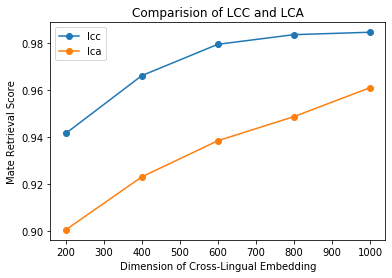

In [60]:
import matplotlib.pyplot as plt
plt.plot(dimensions, lcc_scores, '-o', label="lcc")
plt.plot(dimensions, lca_scores,'-o',label="lca")
plt.xlabel("Dimension of Cross-Lingual Embedding")
plt.ylabel("Mate Retrieval Score")
plt.title("Comparision of LCC and LCA")
plt.legend()